In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io

In [2]:
io.ImageCollection()

In [3]:
pano_imgs = io.ImageCollection(['/Users/amir/Desktop/Filtered Image/Original.jpg', '/Users/amir/Desktop/Filtered Image/Croped.jpg'])

In [4]:
def plot_collage(imgs, columns, rows, figsize):
    fig=plt.figure(figsize=figsize)
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i-1])
    plt.tight_layout()
    plt.show()

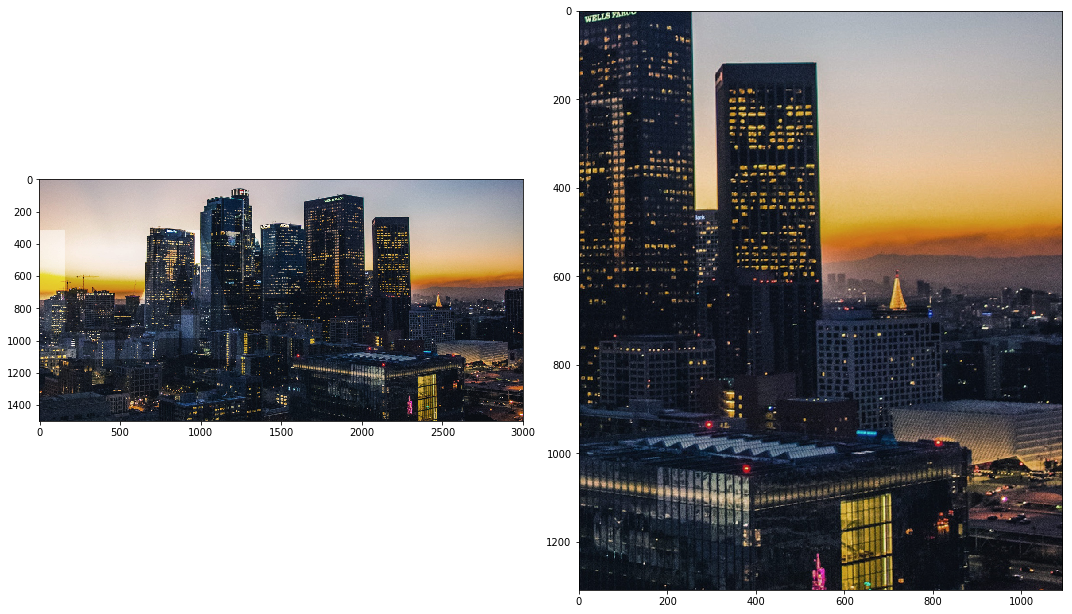

In [6]:
plot_collage(pano_imgs, 2, 1, (15, 10))

## Описание решения (также комментарии есть в коде)
### Препроцессинг
Как видно, изображение довольно громоздкие, и вычислительно обрабатывать исходный размер довольно сложно. В связи с чем я сжал все в 4 раза.
### Подсчет дескрипторов ORB
Здесь основная проблема в моей панораме заключалась в том, что keypoints, которые находились очень сильно зашумлялись из-за машин и деревьев, в связи с чем находились неверные гомографии для пар изображений, это влекло за собой неверную склейку. Поэтому мной было решено подсчитывать дескрипторы по маске, тем самым исключая "проблемные" зоны. Ниже, чтобы не быть голословным, пример плохого нахождения keypoints на двух соседних изображениях.

Было замечено, что особо гиперпараметры у ORB не влеяют на итоговый результат, кол-во ключевых точек более 800, все дают приблезительно одно и тоже (я выбрал 3000), а порог 0.01 - 0.2 также приблезительно одинаково влияет на итог.

/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


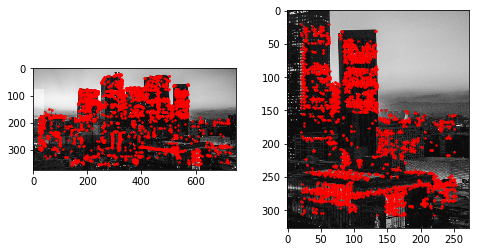

In [9]:
from skimage.feature import ORB
from skimage.color import rgb2gray
from skimage.transform import rescale

orb = ORB(n_keypoints=3000, fast_threshold=0.01)

pano6 = rgb2gray(rescale(pano_imgs[0], 0.25))
orb.detect_and_extract(rgb2gray(rescale(pano_imgs[0], 0.25)))
keypoints6 = orb.keypoints

pano7 = rgb2gray(rescale(pano_imgs[1], 0.25))
orb.detect_and_extract(rgb2gray(rescale(pano_imgs[1], 0.25)))
keypoints7 = orb.keypoints

fig=plt.figure(figsize=(8, 4))
fig.add_subplot(1, 2, 1)
plt.imshow(pano6, zorder=1, cmap='gray')
plt.scatter(keypoints6[:,1], keypoints6[:,0], zorder=2, s=2.0, color='red')

fig.add_subplot(1, 2, 2)
plt.imshow(pano7, zorder=1, cmap='gray')
plt.scatter(keypoints7[:,1], keypoints7[:,0], zorder=2, s=2.0, color='red')

plt.show()

### Выбор пар изображений
Как было сказано на семинаре, я воспользовался тем, что мы изначально знаем о пространственном положении поданных картинок в панораме. Я попробовал выбирать пары эвристически - через подсчитывания количества сопоставленных дескрипторов, однако оснвная проблема здесь была в том, что на некоторых семействах изображений пересечение довольно сильные, в связи с чем итоговый полученный граф мог быть неверным (или не таким хорошим), т.к. иногда получалось так, что у промежуточного изображения между двумя было меньше сопоставленных дескрипторов.

В итоге на вход функция принимает список изображений, в каком порядки они и должны идти в итоговой панораме.

### Применение найденных гомографий, перевод всех изображений в одну плоскость.
Основная проблема здесь заключалось в том, что я забыл об несиметричности композиции афинных преобразований, в связи с чем поначалу не получался хороший перевод всех изображений в одну плоскость после нахождения гомографий. Сам же перевод осуществлялся при помощи skimage.transform.warp .

### Смешивание, склейка
После перевода всех изображений в одну плоскость, я получал изображение фотографии и ее место на итоговой панораме + маску. Очевидно при обычном наложении полученных изображений на итоговую панораму получались швы, чтобы их устранить я воспользовался склейкой изображений при помощи пирамиды Лапласа. Однако здесь возникла проблема с тем, что при обычном подаче маски (где 1 - левое изображение, а 0 - правое) на склейку, швы немного размывались, но сама темнота не уходила, поэтому мною было принято решение расширить маску, после чего склейка уже выполнялась намного лучше.

Сама склейка производилась поэтапно, сначало 1 и 2, потом полученный результат с 3 и так далее. Также пробовался вариант с попарной склейкой, т.е. 1 и 2, 3 и 4, потом полученные результаты между собой и т.д. Особо разницы на выходе я не заметил, однако во втором случае склейка занимала дольше времени.

Также в реализации было много параметров для тюнинга - размер гауссовского ядра, сигма и т.д. В итоге наиболее качественный на мой взгляд результат был достигнут при размере ядра = 5, и sigma=10, итоговое панорама получалось довольно четкой (не размытой), а сами швы почти невидны. Однако Вы можете варьировать данные параметры для более сильного "затирания" швов склейки, но тогда получите более размытую итоговую панораму.

### Итог
После получения итоговой панорамы я обрезал ее края, что бы не было видно черного фона, который получился при переносе всех изображений в одну плоскость. Итоговая панорама на мой взгляд получилась довольно красивой, нету перепада цветов, изображение довольно четкое, швов склейки, почти не видно.

In [10]:
# Реализация Лапласовской пирамиды и функции склейки двух изображений по маске. В качестве дефолтного
# гиперпараметра выступает n_layers=5
from scipy.ndimage.filters import convolve
from scipy.stats import norm
  
    
def create_gauss_kernel(sigma, kernel_size):
    interval = (2*sigma + 1.)/kernel_size
    x = np.linspace(-sigma-interval/2, sigma+interval/2, kernel_size+1)
    kernel = np.diff(norm.cdf(x))
    kernel = np.sqrt(np.outer(kernel, kernel))
    kernel_normalized = kernel/kernel.sum()
    return kernel_normalized


def gaussian_pyramid(img, sigma, n_layers, kernel_size):
    gauss_kernel = create_gauss_kernel(sigma, kernel_size)
    gauss_kernel = gauss_kernel[:,:,None]
    gauss_pyramid = []
    gauss_pyramid.append(convolve(img, gauss_kernel, mode='constant', cval=0.0))
    for i in range(1, n_layers):
        output = convolve(gauss_pyramid[-1], gauss_kernel, mode='constant', cval=0.0)
        gauss_pyramid.append(output)
    return gauss_pyramid


def laplacian_pyramid(img, sigma, n_layers, kernel_size):
    laplac_pyram = []
    gauss_pyram = gaussian_pyramid(img, sigma, n_layers-1, kernel_size)
    laplac_pyram.append(img - gauss_pyram[0])
    for i in range(1, n_layers-1):
        laplac_pyram.append(gauss_pyram[i] - gauss_pyram[i-1])
    laplac_pyram.append(gauss_pyram[i])
    return laplac_pyram


def combine_2imgs(imgA, imgB, mask, sigma, n_layers=5, kernel_size=10):
    A_pyramid = laplacian_pyramid(imgA, sigma, n_layers, kernel_size)
    print("Pyramid for the first image build")
    B_pyramid = laplacian_pyramid(imgB, sigma, n_layers, kernel_size)
    print("Pyramid for the second image build")
    mask_gauss = gaussian_pyramid(mask, sigma, n_layers, kernel_size)
    print("Mask gaussian build")
    if len(mask_gauss) == len(B_pyramid) == len(A_pyramid):
        print("All dimensions are the same, all OK")
    result_img = np.zeros(A_pyramid[0].shape)
    for i in range(len(mask_gauss)):
        result_img += (A_pyramid[i]*mask_gauss[i] + B_pyramid[i]*(1-mask_gauss[i]))
    return result_img

In [11]:
from skimage.color import rgb2gray
from skimage.transform import rescale

pano = []
scale_factor = 1
for i in range(2):
    if i != 4:
        pano.append(rgb2gray(rescale(pano_imgs[i], 0.25*scale_factor)))

IndexError: There are only 2 images in the collection

In [22]:
from skimage.feature import ORB
from skimage.feature import match_descriptors
from skimage.transform import AffineTransform
from skimage.measure import ransac
from skimage.transform import SimilarityTransform
from skimage.transform import warp

def find_homography_masks(pano, center = 3):
    orb = ORB(n_keypoints=3000, fast_threshold=0.01)
    # Нахождение дескрипторов и кейпоинтов по маске, а не по всему изображению
    keypoints = []
    descriptors = []
    for i in range(8):
        mask = pano[i].copy()
        mask[500*scale_factor:,:] = 0
        orb.detect_and_extract(mask)
        keypoints.append(orb.keypoints)
        descriptors.append(orb.descriptors)
    # Сопоставление дескрипторов
    matches = []
    for i in range(1, 8):
        matches.append(match_descriptors(descriptors[i-1], descriptors[i], cross_check=True))
        
    model_robust = []
    # Отсеивание при помощи RANSAC
    for i in range(7):
        if i < center:
            src = keypoints[i][matches[i][:, 0]][:, ::-1]
            dst = keypoints[i+1][matches[i][:, 1]][:, ::-1]
        else:
            src = keypoints[i+1][matches[i][:, 1]][:, ::-1]
            dst = keypoints[i][matches[i][:, 0]][:, ::-1]
        _model_robust, _inliers = ransac((src, dst), AffineTransform,
                                       min_samples=4, residual_threshold=1, max_trials=300)
        model_robust.append(_model_robust)
    # Перевод в одну плоскость по полученным гомографиям, создания черного полотна панорамы
    # и навешивание на него изображений
    r, c = pano[center].shape[:2]
    corners = np.array([[0, 0],
                        [0, r],
                        [c, 0],
                        [c, r]])
    warped_corners = []
    warped_corners.append(model_robust[center-1](corners))
    for i in range(center-2, -1, -1):
        warped_corners.append(model_robust[i](warped_corners[-1]))
    warped_corners = warped_corners[::-1]
    warped_corners.append(model_robust[center](corners))
    for i in range(center+1, 7):
        warped_corners.append(model_robust[i](warped_corners[-1]))
    all_corners = np.vstack((warped_corners[0], warped_corners[1], warped_corners[2], warped_corners[3], 
                             warped_corners[4], warped_corners[5], warped_corners[6], corners))

    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)
    output_shape = (corner_max - corner_min)
    
    output_shape = np.ceil(output_shape[::-1]).astype(int)
    offset1 = SimilarityTransform(translation= -corner_min)

    pan_warp = []
    pan_mask = []
    transform = []
    for i in range(8):
        cur_offset = AffineTransform()
        if i < center:
            for j in range(i, center):
                cur_offset += model_robust[j]
        elif i > center:
            for j in range(i-1, center-1, -1):
                cur_offset += model_robust[j]
        cur_offset += offset1
        transform.append((cur_offset).inverse)
        pano0_warped = warp(pano[i], transform[-1], order=3, output_shape=output_shape, cval=-1)
        pano0_mask = (pano0_warped != -1)
        pano0_warped[~pano0_mask] = 0      
        pan_warp.append(pano0_warped)
        pan_mask.append(pano0_mask)
    return pan_mask, pan_warp, transform, output_shape

In [23]:
pan_mask, pan_warp, transform, output_shape = find_homography_masks(pano)

/home/artem/anaconda3/lib/python3.6/site-packages/skimage/feature/match.py:49: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  if np.issubdtype(descriptors1.dtype, np.bool):


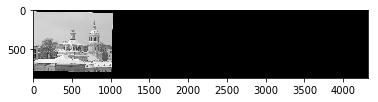

In [24]:
# Чекним, что все ок
plt.imshow(pan_warp[0], cmap='gray')

/home/artem/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


807
Pyramid for the first image build
Pyramid for the second image build
Mask gaussian build
All dimensions are the same, all OK
1357
Pyramid for the first image build
Pyramid for the second image build
Mask gaussian build
All dimensions are the same, all OK
1797
Pyramid for the first image build
Pyramid for the second image build
Mask gaussian build
All dimensions are the same, all OK
2375
Pyramid for the first image build
Pyramid for the second image build
Mask gaussian build
All dimensions are the same, all OK
2941
Pyramid for the first image build
Pyramid for the second image build
Mask gaussian build
All dimensions are the same, all OK
3258
Pyramid for the first image build
Pyramid for the second image build
Mask gaussian build
All dimensions are the same, all OK
3615
Pyramid for the first image build
Pyramid for the second image build
Mask gaussian build
All dimensions are the same, all OK


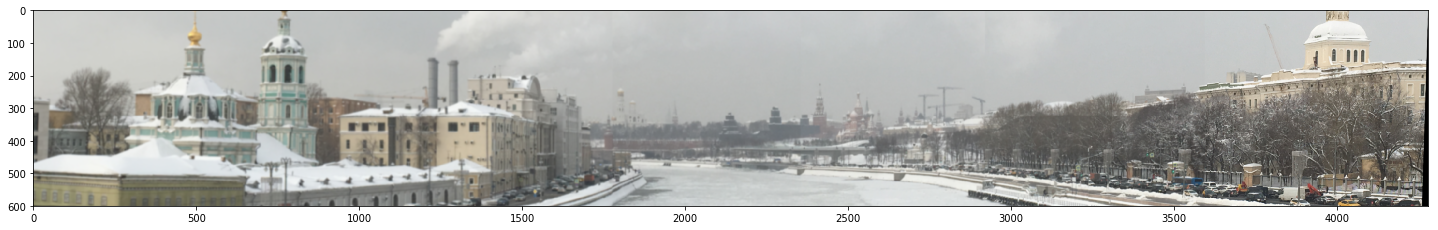

In [25]:
# Переведем в цвет и склеем

def intersec_mask(mask1, mask2):
    intersec = (mask1 & mask2)*1.0
    mean_line_mask = np.int(np.mean([np.argwhere(intersec == 1.0)[:,1].max(), np.argwhere(intersec == 1.0)[:,1].min()]))
    print(mean_line_mask)
    new_mask = np.zeros(intersec.shape)
    new_mask[:,:mean_line_mask,:] = 1.0
    return new_mask


def blending(pano, transform, output_shape):
    pan_warp = []
    pan_mask = []
    for i in range(8):
        pano0_warped = warp(pano[i], transform[i], order=3, output_shape=output_shape, cval=-1)
        pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
        pano0_warped[~pano0_mask] = 0
        pan_warp.append(pano0_warped)
        pan_mask.append(pano0_mask)

    cur_mask = pan_mask[0]
    masks = []
    result = [pan_warp[0]]
    for i in range(1, 8):
        result.append(combine_2imgs(result[-1], pan_warp[i], 
                               mask=intersec_mask(cur_mask, pan_mask[i]), sigma=10, kernel_size=5))
        cur_mask = cur_mask | pan_mask[i]
        masks.append(cur_mask)
    return result


pano = []
scale_factor = 1
for i in range(9):
    if i != 4:
        pano.append(rescale(pano_imgs[i], 0.25*scale_factor))
        
result = blending(pano, transform, output_shape)

result[-1] = np.maximum(0, result[-1])
plt.figure(figsize=(25, 20))

# Обрежим изображение
plt.imshow(result[-1][180:780,20:4300])

### Полученное изображение меньше в 4 раза, однако довольно четкое и панорама вроде бы красивая :)